In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import pairwise_distances
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Import our custom library
import network_reconstruction as nr

# Set random seed for reproducibility
np.random.seed(42)

# Generate Scale-free Network

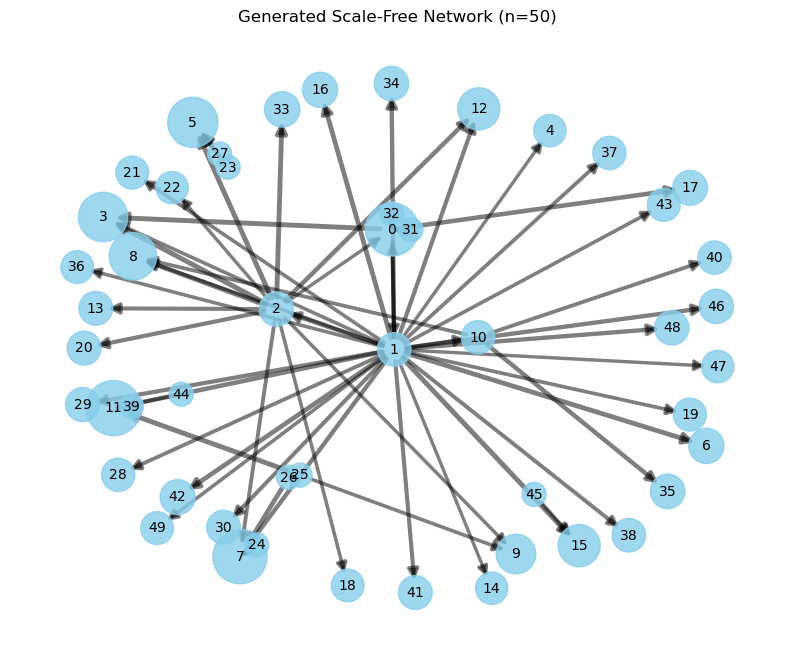

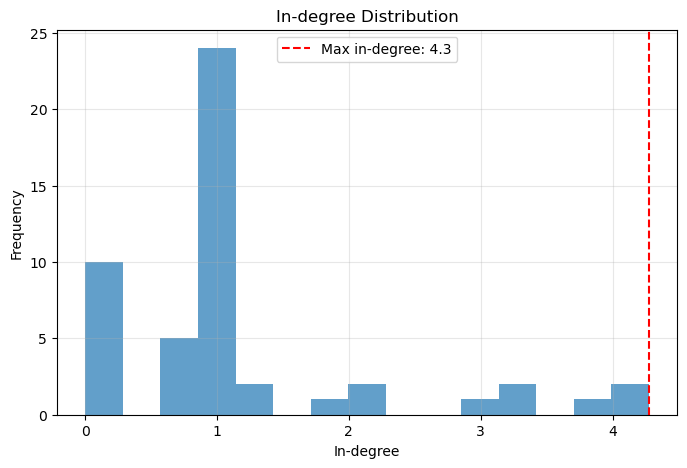

Network generated with 50 nodes and 58 edges
Maximum in-degree: 4.28
Hub node: 11 with in-degree 4.28


In [2]:
# Network parameters
n = 50  # Number of nodes
eta = 0.2  # Range for random weights [1-eta, 1+eta]

# Generate network
G, A, k_in, L_true, delta = nr.generate_scale_free_network(n, eta)

# Visualize network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Calculate node sizes based on in-degree
node_sizes = [300 * (1 + k) for k in k_in]

# Calculate edge widths based on weights
edge_weights = [3 * d['weight'] for u, v, d in G.edges(data=True)]

# Draw the network
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.8, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, arrowsize=15)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title(f"Generated Scale-Free Network (n={n})")
plt.axis('off')
plt.show()

# Plot in-degree distribution
plt.figure(figsize=(8, 5))
degrees = list(k_in)
plt.hist(degrees, bins=15, alpha=0.7)
plt.axvline(x=np.max(degrees), color='r', linestyle='--', label=f'Max in-degree: {np.max(degrees):.1f}')
plt.xlabel('In-degree')
plt.ylabel('Frequency')
plt.title('In-degree Distribution')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Network generated with {n} nodes and {G.number_of_edges()} edges")
print(f"Maximum in-degree: {np.max(k_in):.2f}")
print(f"Hub node: {np.argmax(k_in)} with in-degree {np.max(k_in):.2f}")

# Generate Time Series Data

Generating time series data from coupled Rulkov maps...
Generated time series data of shape: (50, 2, 500)
This represents 50 nodes with 2 variables each, over 500 time steps


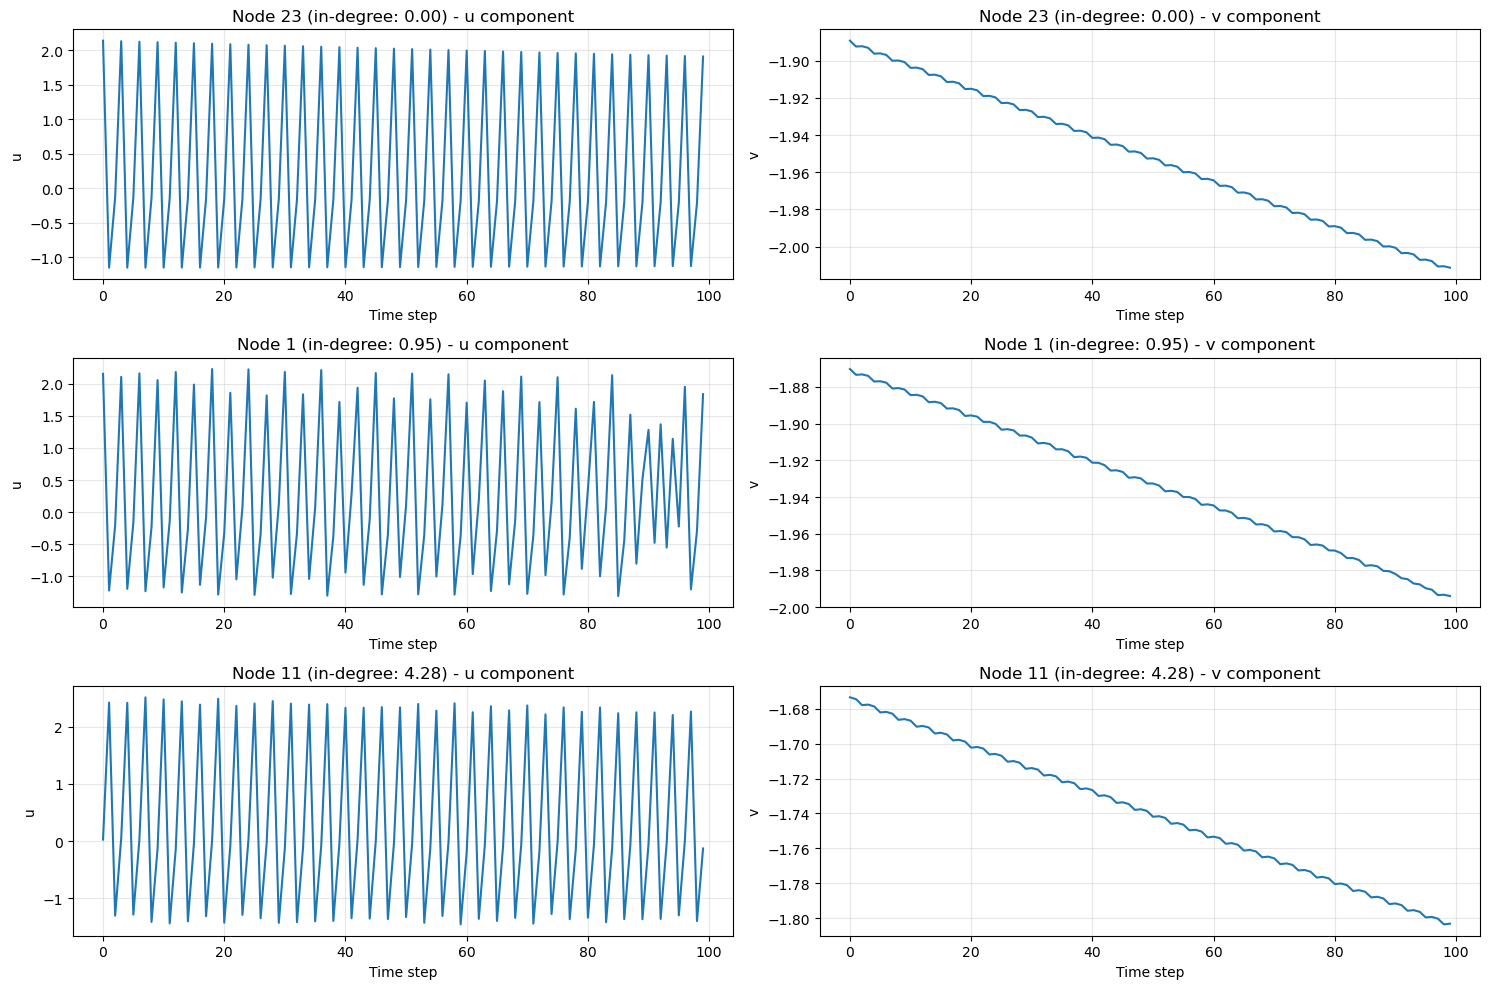

In [3]:
# Simulation parameters
m = 2  # Dimension of node state (u and v for Rulkov map)
transient = 1000  # Number of steps to discard as transient
time_steps = 500  # Number of time steps to simulate

# Rulkov map parameters
beta = 4.1
mu = 0.001
sigma = 0.001

# Coupling setup
C = 0.1  # Coupling strength
h = np.eye(m)  # Coupling matrix
h[1, 1] = 0  # Only couple u component, not v

# Noise setup
x_noise = np.zeros(n*m)  # Noise mask
for i in range(n*m):
    if i % 2 == 0:  # Apply noise only to u component
        x_noise[i] = 1
gamma = 0.0  # Noise intensity (set to 0 for now)

# Generating time series data
print("Generating time series data from coupled Rulkov maps...")
x = nr.generate_data(n, m, transient, time_steps, beta, mu, sigma, C, L_true, delta, h, gamma, x_noise)

print(f"Generated time series data of shape: {x.shape}")
print(f"This represents {n} nodes with {m} variables each, over {time_steps} time steps")

# Plot time series for a few selected nodes
plt.figure(figsize=(15, 10))

# Select nodes to plot: one low-degree, one medium-degree, and the hub
nodes_to_plot = [
   np.argmin(k_in),  # Lowest in-degree node
   np.argsort(k_in)[n//2],  # Medium in-degree node
   np.argmax(k_in)  # Hub node
]

for i, node_id in enumerate(nodes_to_plot):
   plt.subplot(3, 2, 2*i+1)
   plt.plot(x[node_id, 0, :100])
   plt.title(f"Node {node_id} (in-degree: {k_in[node_id]:.2f}) - u component")
   plt.xlabel("Time step")
   plt.ylabel("u")
   plt.grid(alpha=0.3)
   
   plt.subplot(3, 2, 2*i+2)
   plt.plot(x[node_id, 1, :100])
   plt.title(f"Node {node_id} (in-degree: {k_in[node_id]:.2f}) - v component")
   plt.xlabel("Time step")
   plt.ylabel("v")
   plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# Split Data for Analysis
# Split data into input-output pairs for regression
X, dx = nr.split_data(n, x)

print(f"Input data X shape: {X.shape}")
print(f"Output data dx shape: {dx.shape}")
print("This gives us input-output pairs for each node and time step")

Input data X shape: (50, 2, 499)
Output data dx shape: (50, 2, 499)
This gives us input-output pairs for each node and time step


# Create Library of Basis Functions

In [5]:
# Create library of basis functions for sparse regression
library_functions, library_function_names = nr.create_library_functions()

print(f"Created library with {len(library_functions)} custom functions")
print("These functions include:")
for func_name in [f('x') for f in library_function_names]:
    print(f"  - {func_name}")
print("Plus polynomial terms (constant, linear, quadratic) will be added during feature building")

Created library with 9 custom functions
These functions include:
  - sin(x)
  - cos(x)
  - 1/1-x
  - 1/1-x^2
  - 1/(1-x)^2
  - 1/1+x
  - 1/1+x^2
  - 1/(1+x)^2
  - 1/x
Plus polynomial terms (constant, linear, quadratic) will be added during feature building


# Perform Sparse Regression to Get Models for Each Node

In [6]:
# Compute predicted models for each node using sparse regression
print("Performing sparse regression to identify models for each node...")
coeff = nr.predict_models(n, X, dx, library_functions, library_function_names)

print(f"Generated model coefficients of shape: {coeff.shape}")
print("This represents coefficients for each node, state variable, and basis function")

# Display a few coefficients for comparison
print("\nExample coefficients for u-component models:")
# Create feature matrix for a sample node to get feature names
sample_node = 0
sample_features = X[sample_node].T
Theta, feature_names = nr.build_feature_matrix(sample_features, library_functions, library_function_names)

# Display coefficients for a few nodes
nodes_to_display = [
    np.argmin(k_in),  # Lowest in-degree node
    np.argsort(k_in)[n//2],  # Medium in-degree node
    np.argmax(k_in)  # Hub node
]

# Show top 5 coefficients by magnitude for each node
for node_id in nodes_to_display:
    coef_u = coeff[node_id, 0, :]  # u-component coefficients
    top_indices = np.argsort(np.abs(coef_u))[-5:]  # Top 5 by magnitude
    
    print(f"\nNode {node_id} (in-degree: {k_in[node_id]:.2f}):")
    for idx in top_indices:
        if idx < len(feature_names):  # Make sure index is valid
            print(f"  {feature_names[idx]}: {coef_u[idx]:.6f}")

Performing sparse regression to identify models for each node...
Generated model coefficients of shape: (50, 2, 24)
This represents coefficients for each node, state variable, and basis function

Example coefficients for u-component models:

Node 23 (in-degree: 0.00):
  u^2: -0.033846
  1/(1+v)^2: -0.047790
  v^2: -0.087651
  v: 0.732188
  1/1+u^2: 3.953078

Node 1 (in-degree: 0.95):
  1/(1+v)^2: -0.029661
  u^2: -0.043342
  v^2: -0.082968
  v: 0.738368
  1/1+u^2: 3.940442

Node 11 (in-degree: 4.28):
  sin(u): -0.077275
  u^2: -0.089180
  v^2: -0.199619
  v: 0.401180
  1/1+u^2: 3.661285


# Analyze Similarity Between Models to Classify Nodes

Analyzing similarity between predicted models to classify nodes...
Predicted low-degree node: 41 has 0.98 in connection(s).
Predicted hub: 17 has 1.09 in connection(s).
The real hub is: 11 with 4.28 in connection(s).


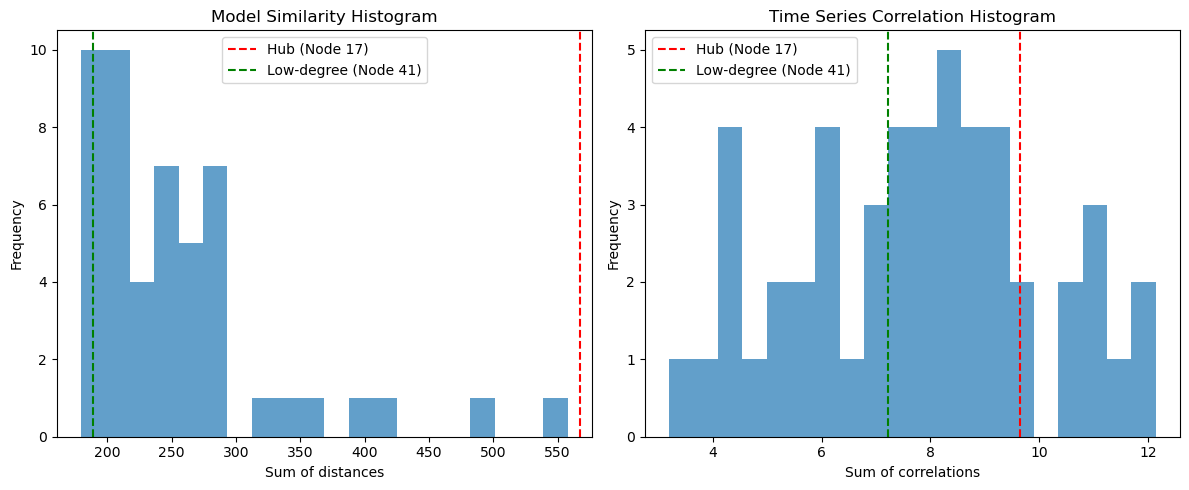

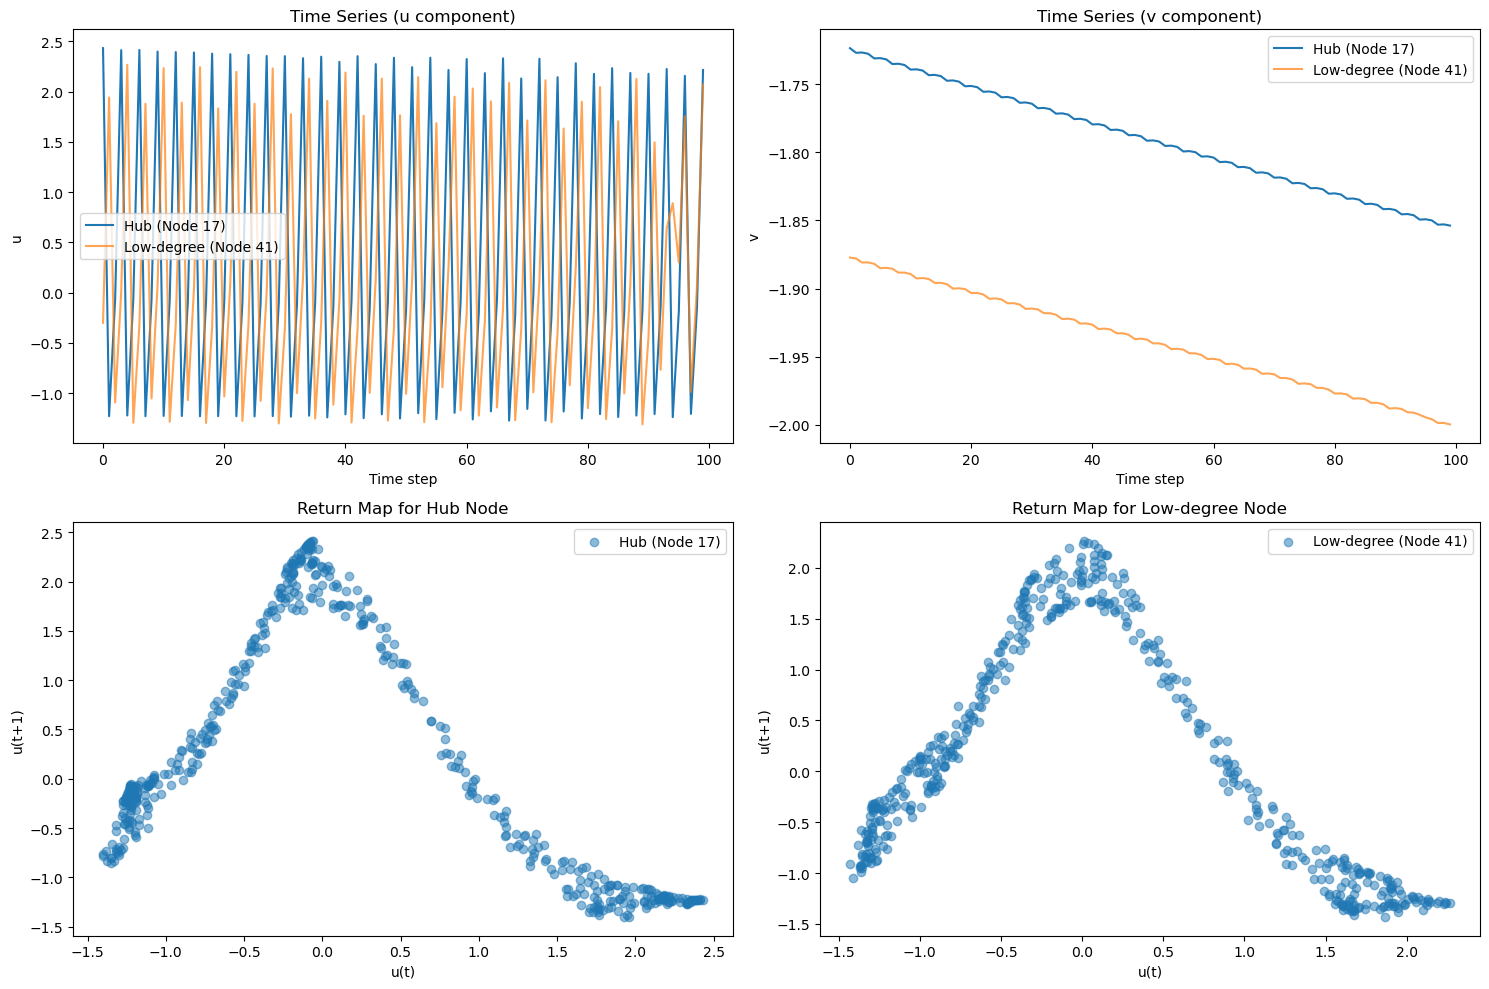


Model-based classification results:
Predicted hub node: 17 with actual in-degree 1.09
Predicted low-degree node: 41 with actual in-degree 0.98
True hub node: 11 with in-degree 4.28


In [7]:
# Analyze similarity between predicted models
print("Analyzing similarity between predicted models to classify nodes...")
corr_matrix_gt, distance_matrix, s, s_gt, hub_id, ld_id = nr.analyze_similarity(n, x, coeff, k_in)

# Plot similarity histogram to visualize node classification
nr.plot_similarity_histogram(s, s_gt, hub_id, ld_id)

# Plot time series and return maps for hub and low-degree nodes
nr.plot_hub_low_degree_data(x, hub_id, ld_id)

print("\nModel-based classification results:")
print(f"Predicted hub node: {hub_id} with actual in-degree {k_in[hub_id]:.2f}")
print(f"Predicted low-degree node: {ld_id} with actual in-degree {k_in[ld_id]:.2f}")
print(f"True hub node: {np.argmax(k_in)} with in-degree {np.max(k_in):.2f}")

# Extract Local Dynamics and Coupling Function

Extracting local dynamics (Rulkov map)...
Extracted local dynamics of shape: (50, 2, 500)
Extracting coupling effect...
Extracted coupling effect on hub: (2, 499)
Extracted coupling effect on all nodes: (50, 2, 499)


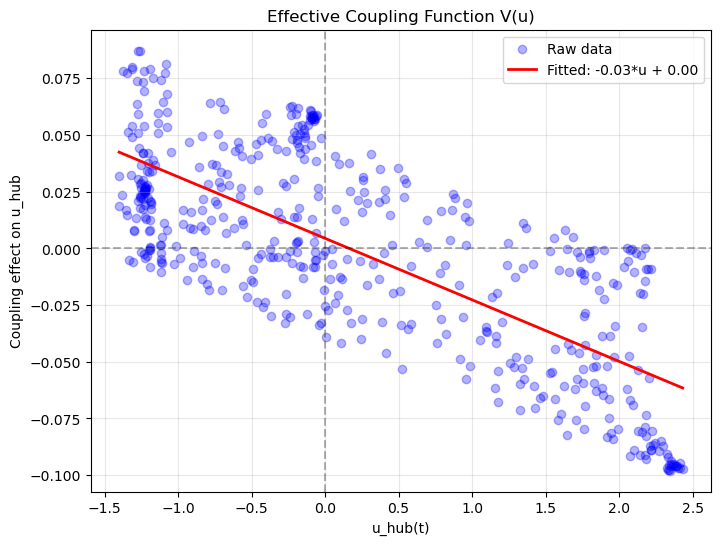

Estimated coupling function: V(u) ≈ -0.0271*u + 0.0044
According to the reduction theorem, this suggests H(u) ≈ -0.0271*u
with a linear shift (integration constant) C ≈ 0.0044


In [8]:
# Extract local dynamics
print("Extracting local dynamics (Rulkov map)...")
Fx = nr.extract_local_dynamics(n, m, time_steps, x, beta, mu, sigma)

print(f"Extracted local dynamics of shape: {Fx.shape}")

# Extract coupling effect
print("Extracting coupling effect...")
Y_hub, Y = nr.extract_coupling_effect(dx, hub_id, Fx)

print(f"Extracted coupling effect on hub: {Y_hub.shape}")
print(f"Extracted coupling effect on all nodes: {Y.shape}")

# Plot the coupling function based on hub data
nr.plot_coupling_function(Y_hub, x, hub_id)

# Reconstruct Network Connectivity

Reconstructing network connectivity using sparse regression...
Reconstruction complete with:
  - False Negative Rate (FNR): 0.0000
  - False Positive Rate (FPR): 0.0164


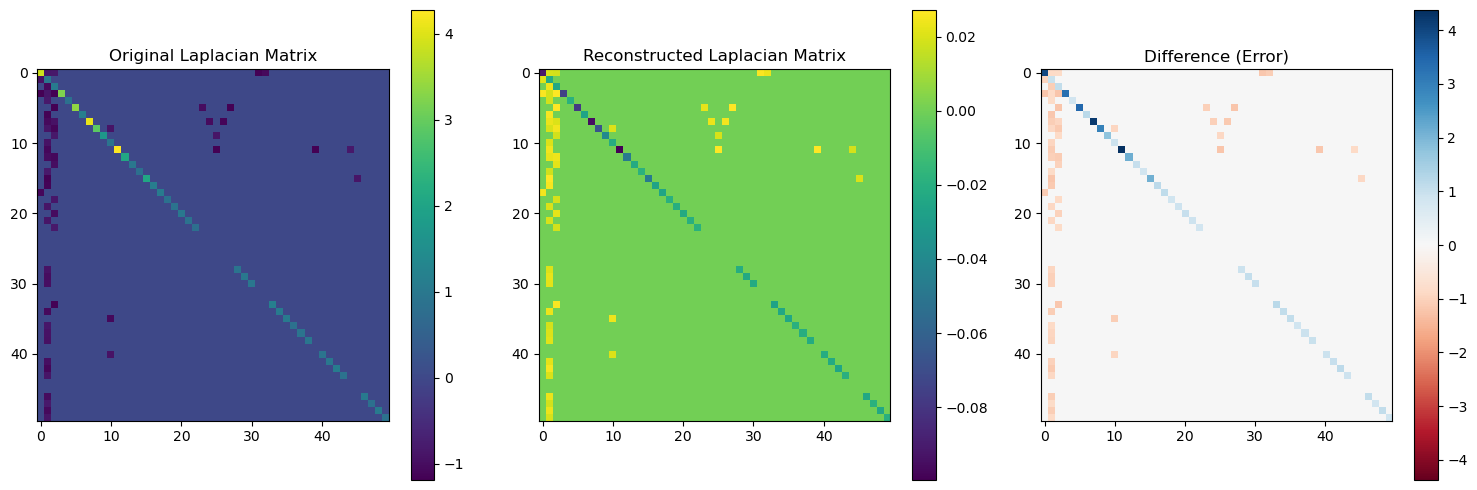

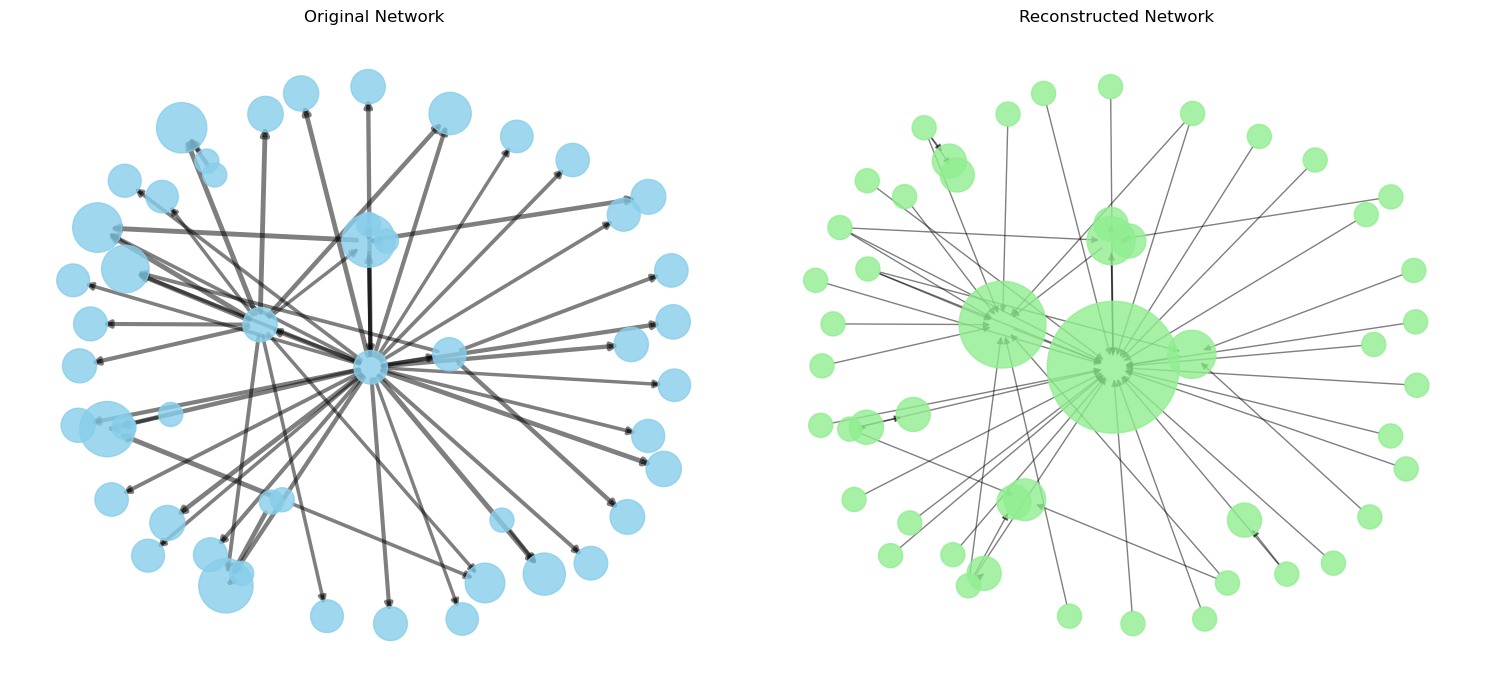

In [9]:
# Reconstruct network using sparse regression
print("Reconstructing network connectivity using sparse regression...")
L_predicted = nr.reconstruct_network(n, m, time_steps, X, Y)

# Evaluate reconstruction performance
FNR, FPR = nr.evaluate_reconstruction(L_true, L_predicted)

print(f"Reconstruction complete with:")
print(f"  - False Negative Rate (FNR): {FNR:.4f}")
print(f"  - False Positive Rate (FPR): {FPR:.4f}")

# Visualize reconstruction results
nr.plot_reconstruction_results(L_true, L_predicted)

# Show adjacency matrix recovered from Laplacian
# Get diagonal elements (in-degrees)
k_predicted = np.diag(L_predicted).copy()

# Recover adjacency matrix: A = diag(k) - L
A_predicted = np.diag(k_predicted) - L_predicted

# Zero out small values
threshold = 1e-3
A_predicted[np.abs(A_predicted) < threshold] = 0

# Create recovered graph
G_predicted = nx.DiGraph(A_predicted)

# Visualize original vs. reconstructed networks side by side
plt.figure(figsize=(15, 7))

# Original network
plt.subplot(1, 2, 1)
pos = nx.spring_layout(G, seed=42)  # Use same layout for both
node_sizes = [300 * (1 + k) for k in k_in]
edge_weights = [3 * d['weight'] for u, v, d in G.edges(data=True)]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.8, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, arrowsize=10)
plt.title("Original Network")
plt.axis('off')

# Reconstructed network
plt.subplot(1, 2, 2)
node_sizes_pred = [300 * (1 + G_predicted.in_degree(i)) for i in range(n)]
nx.draw_networkx_nodes(G_predicted, pos, node_size=node_sizes_pred, alpha=0.8, node_color='lightgreen')
nx.draw_networkx_edges(G_predicted, pos, alpha=0.5, arrowsize=10)
plt.title("Reconstructed Network")
plt.axis('off')

plt.tight_layout()
plt.show()

## Different Time Series Lengths

Testing reconstruction with different time series lengths...
 FNR: 0.3621, FPR: 0.0557..
 FNR: 0.1552, FPR: 0.0520...
 FNR: 0.0000, FPR: 0.0209...
 FNR: 0.0000, FPR: 0.0168...
 FNR: 0.0000, FPR: 0.0164...
 FNR: 0.0000, FPR: 0.0164...


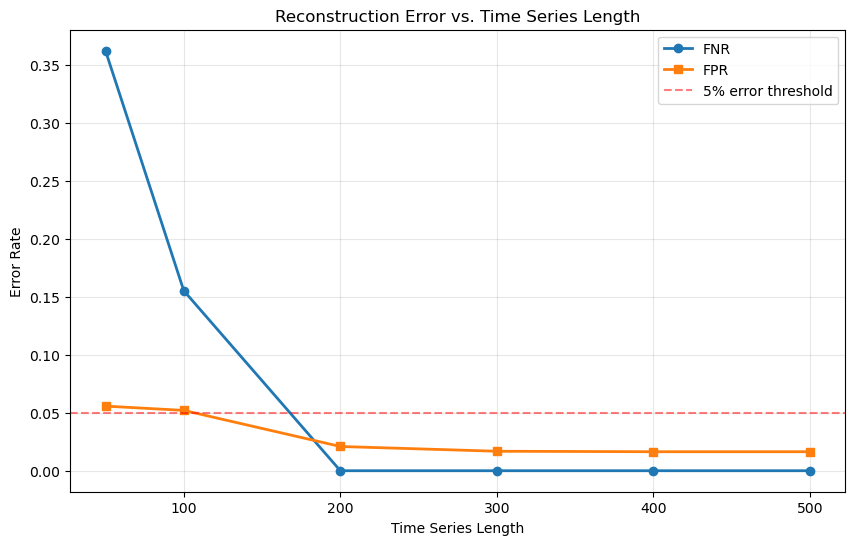


Conclusion:
The results show how reconstruction performance improves with longer time series.
This matches the findings in the paper that reconstruction is possible with relatively short time series.


In [10]:
# Test reconstruction with different time series lengths
time_lengths = [50, 100, 200, 300, 400, 500]
fnr_results = []
fpr_results = []

print("Testing reconstruction with different time series lengths...")

for t_length in time_lengths:
    print(f"  - Processing length {t_length}...", end="")
    
    # Use only a subset of the data
    X_subset = X[:, :, :t_length-1]
    Y_subset = Y[:, :, :t_length-1]
    
    # Reconstruct network with this subset
    L_pred = nr.reconstruct_network(n, m, t_length, X_subset, Y_subset)
    
    # Evaluate
    fnr, fpr = nr.evaluate_reconstruction(L_true, L_pred)
    fnr_results.append(fnr)
    fpr_results.append(fpr)
    
    print(f" FNR: {fnr:.4f}, FPR: {fpr:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_lengths, fnr_results, 'o-', label='FNR', linewidth=2)
plt.plot(time_lengths, fpr_results, 's-', label='FPR', linewidth=2)
plt.axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='5% error threshold')
plt.xlabel('Time Series Length')
plt.ylabel('Error Rate')
plt.title('Reconstruction Error vs. Time Series Length')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\nConclusion:")
print("The results show how reconstruction performance improves with longer time series.")
print("This matches the findings in the paper that reconstruction is possible with relatively short time series.")

## Different Network Sizes

Testing reconstruction with different network sizes...
This will take some time to run...
Predicted low-degree node: 14 has 0.95 in connection(s).
Predicted hub: 7 has 2.90 in connection(s).
The real hub is: 7 with 2.90 in connection(s).
 FNR: 0.0000, FPR: 0.0369
Predicted low-degree node: 39 has 0.87 in connection(s).
Predicted hub: 0 has 11.94 in connection(s).
The real hub is: 0 with 11.94 in connection(s).
 FNR: 0.0000, FPR: 0.0155
Predicted low-degree node: 47 has 0.93 in connection(s).
Predicted hub: 54 has 0.00 in connection(s).
The real hub is: 0 with 5.34 in connection(s).
 FNR: 0.0000, FPR: 0.0122
Predicted low-degree node: 62 has 0.88 in connection(s).
Predicted hub: 6 has 3.75 in connection(s).
The real hub is: 2 with 5.99 in connection(s).
 FNR: 0.0000, FPR: 0.0103
Predicted low-degree node: 42 has 1.05 in connection(s).
Predicted hub: 2 has 6.61 in connection(s).
The real hub is: 2 with 6.61 in connection(s).
 FNR: 0.0000, FPR: 0.0077


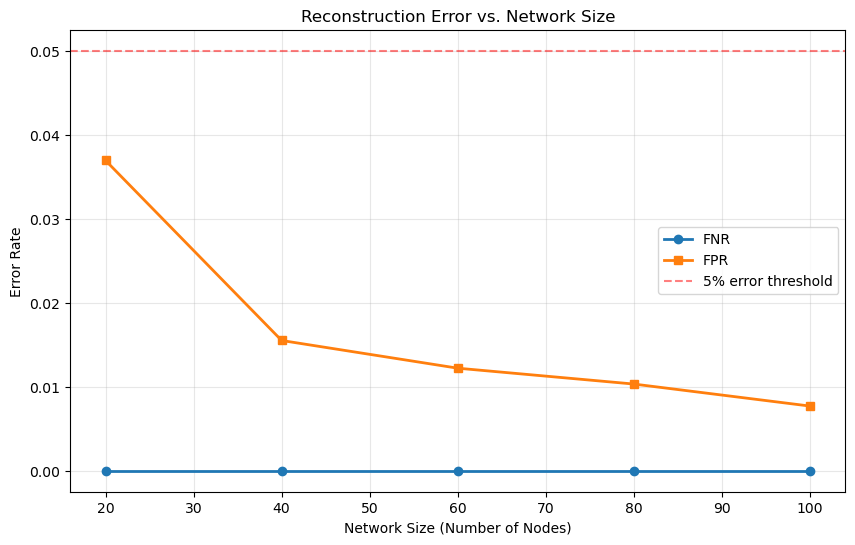


Conclusion:
The results show how reconstruction performance changes with network size.
The method maintains good performance even for larger networks,
which matches the findings in the paper about scalability.


In [12]:
# Test reconstruction with different network sizes
network_sizes = [20, 40, 60, 80, 100]
fnr_by_size = []
fpr_by_size = []

print("Testing reconstruction with different network sizes...")
print("This will take some time to run...")

for size in network_sizes:
    print(f"  - Processing network with {size} nodes...", end="")
    
    # Generate new network of this size
    G_test, A_test, k_in_test, L_test, delta_test = nr.generate_scale_free_network(size, eta)
    
    # Create noise mask for this specific size
    size_x_noise = np.zeros(size*m)
    for i in range(size*m):
        if i % 2 == 0:  # Only u component gets noise
            size_x_noise[i] = 1
    
    # Generate data with the correctly sized noise mask
    x_test = nr.generate_data(size, m, transient, time_steps, beta, mu, sigma, 
                             C, L_test, delta_test, h, gamma, size_x_noise)
    
    # Split data
    X_test, dx_test = nr.split_data(size, x_test)
    
    # Extract local dynamics
    Fx_test = nr.extract_local_dynamics(size, m, time_steps, x_test, beta, mu, sigma)
    
    # Analyze similarity to find hub
    coeff_test = nr.predict_models(size, X_test, dx_test, library_functions, library_function_names)
    _, _, _, _, hub_id_test, _ = nr.analyze_similarity(size, x_test, coeff_test, k_in_test)
    
    # Extract coupling effect
    _, Y_test = nr.extract_coupling_effect(dx_test, hub_id_test, Fx_test)
    
    # Reconstruct network
    L_pred_test = nr.reconstruct_network(size, m, time_steps, X_test, Y_test)
    
    # Evaluate
    fnr, fpr = nr.evaluate_reconstruction(L_test, L_pred_test)
    fnr_by_size.append(fnr)
    fpr_by_size.append(fpr)
    
    print(f" FNR: {fnr:.4f}, FPR: {fpr:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(network_sizes, fnr_by_size, 'o-', label='FNR', linewidth=2)
plt.plot(network_sizes, fpr_by_size, 's-', label='FPR', linewidth=2)
plt.axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='5% error threshold')
plt.xlabel('Network Size (Number of Nodes)')
plt.ylabel('Error Rate')
plt.title('Reconstruction Error vs. Network Size')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\nConclusion:")
print("The results show how reconstruction performance changes with network size.")
print("The method maintains good performance even for larger networks,")
print("which matches the findings in the paper about scalability.")

Generating time series from the reconstructed network for comparison...


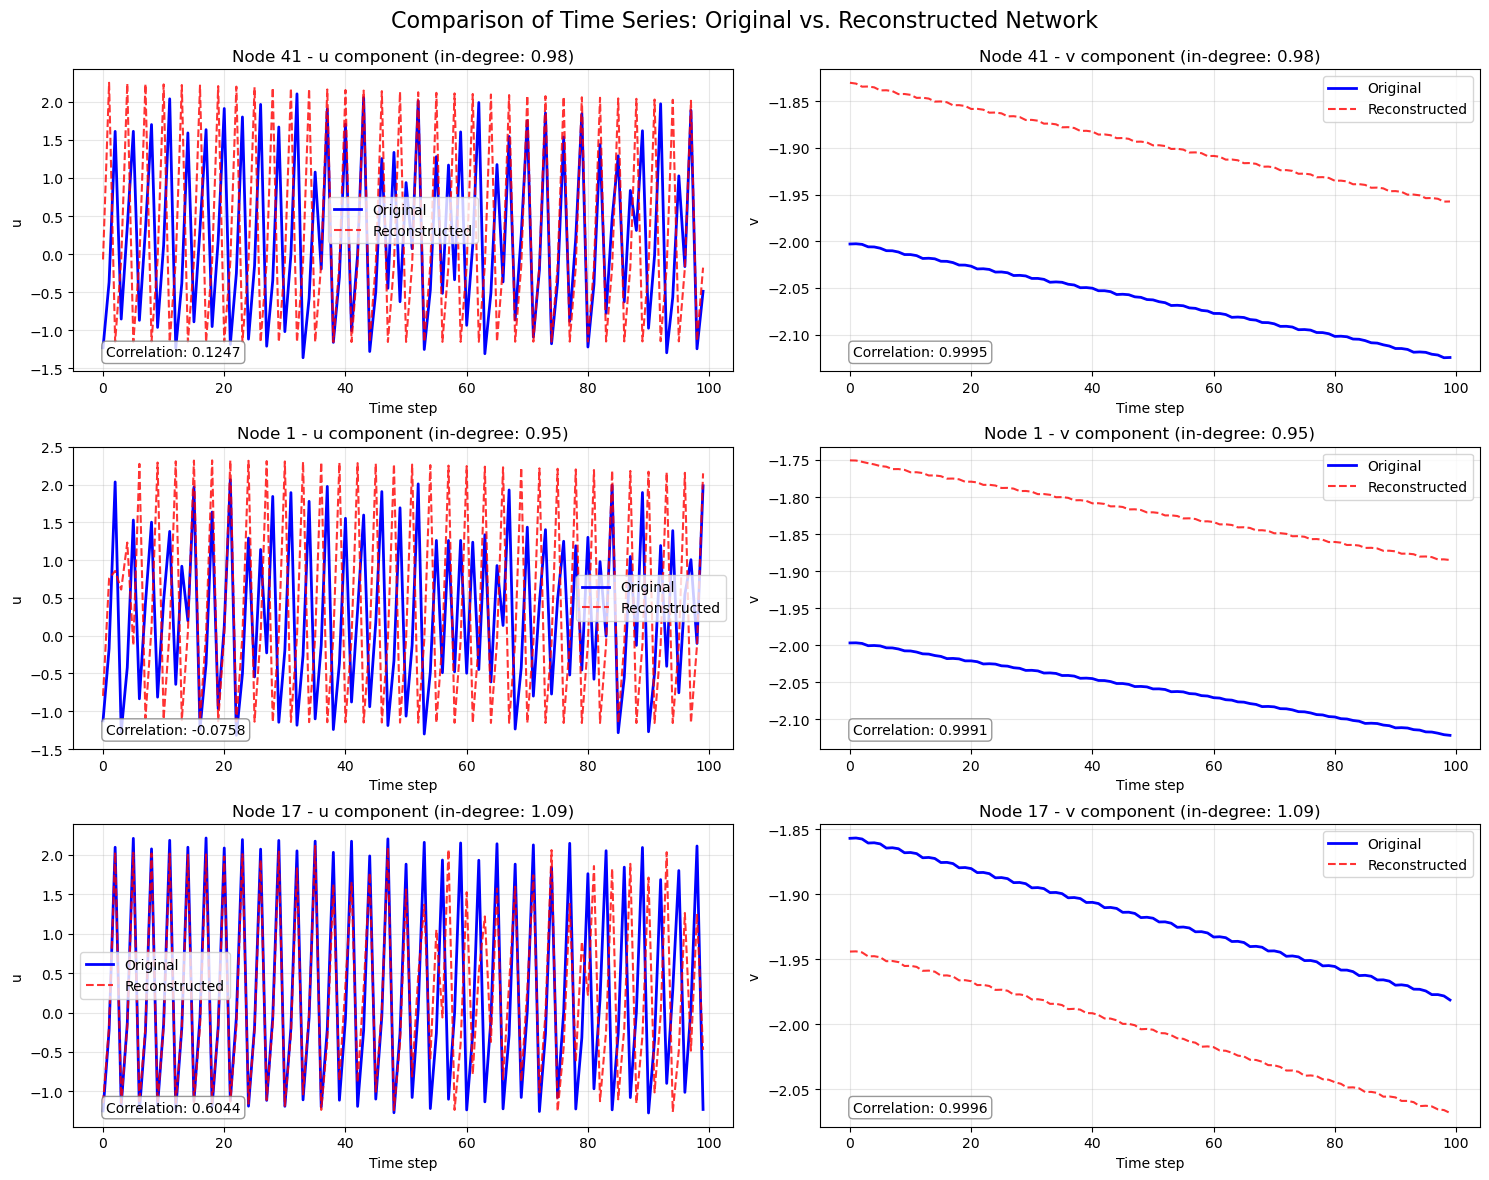

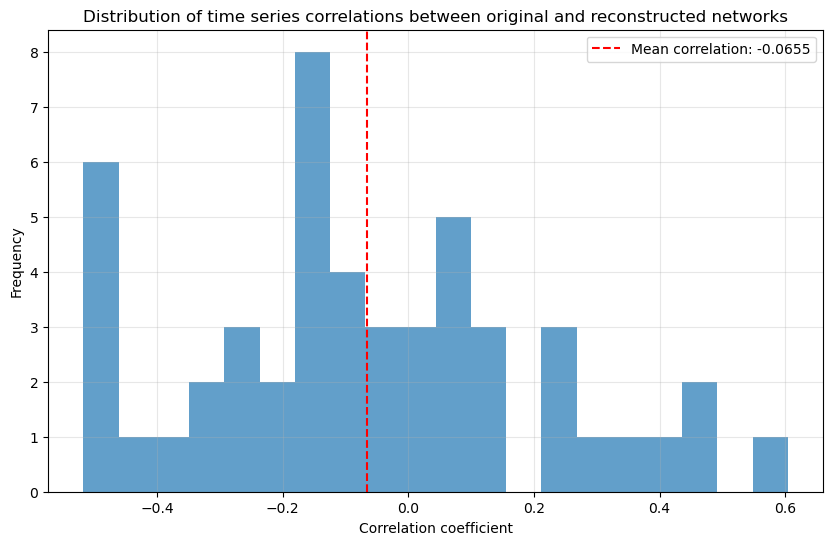


Time series comparison summary:
Mean correlation across all nodes: -0.0655
Median correlation: -0.1117
Minimum correlation: -0.5174
Maximum correlation: 0.6044
Standard deviation of correlations: 0.2750

This comparison shows how well the reconstructed network reproduces
the dynamics of the original network in terms of actual time series data.
High correlations indicate successful reconstruction of both topology and dynamics.


In [13]:
# Compare time series data from original and reconstructed networks
print("Generating time series from the reconstructed network for comparison...")

# Create coupling matrix using reconstructed Laplacian
# We need to ensure it has the right structure for the simulation
h_recon = h.copy()  # Same coupling function as before

# Generate time series data using reconstructed network
x_recon = nr.generate_data(n, m, transient, time_steps, beta, mu, sigma, 
                           C, L_predicted, delta, h_recon, gamma, x_noise)

# Select a few nodes to compare
nodes_to_compare = [
    ld_id,  # Low-degree node
    np.argsort(k_in)[n//2],  # Medium-degree node
    hub_id  # Hub node
]

# Create a figure to display the comparisons
plt.figure(figsize=(15, 12))

for i, node_id in enumerate(nodes_to_compare):
    # Plot u-component
    plt.subplot(3, 2, 2*i+1)
    
    # Original data
    plt.plot(x[node_id, 0, 100:200], 'b-', label='Original', linewidth=2)
    
    # Reconstructed data
    plt.plot(x_recon[node_id, 0, 100:200], 'r--', label='Reconstructed', linewidth=1.5, alpha=0.8)
    
    plt.title(f"Node {node_id} - u component (in-degree: {k_in[node_id]:.2f})")
    plt.xlabel("Time step")
    plt.ylabel("u")
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Compute correlation between original and reconstructed time series
    corr_u = np.corrcoef(x[node_id, 0, 100:200], x_recon[node_id, 0, 100:200])[0, 1]
    plt.annotate(f"Correlation: {corr_u:.4f}", xy=(0.05, 0.05), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # Plot v-component
    plt.subplot(3, 2, 2*i+2)
    
    # Original data
    plt.plot(x[node_id, 1, 100:200], 'b-', label='Original', linewidth=2)
    
    # Reconstructed data
    plt.plot(x_recon[node_id, 1, 100:200], 'r--', label='Reconstructed', linewidth=1.5, alpha=0.8)
    
    plt.title(f"Node {node_id} - v component (in-degree: {k_in[node_id]:.2f})")
    plt.xlabel("Time step")
    plt.ylabel("v")
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Compute correlation between original and reconstructed time series
    corr_v = np.corrcoef(x[node_id, 1, 100:200], x_recon[node_id, 1, 100:200])[0, 1]
    plt.annotate(f"Correlation: {corr_v:.4f}", xy=(0.05, 0.05), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.suptitle("Comparison of Time Series: Original vs. Reconstructed Network", fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()

# Calculate overall similarity between original and reconstructed time series
correlations = []
for node_id in range(n):
    # Compute correlation for each node's u-component
    corr = np.corrcoef(x[node_id, 0, 100:200], x_recon[node_id, 0, 100:200])[0, 1]
    correlations.append(corr)

plt.figure(figsize=(10, 6))
plt.hist(correlations, bins=20, alpha=0.7)
plt.axvline(np.mean(correlations), color='r', linestyle='--', 
            label=f'Mean correlation: {np.mean(correlations):.4f}')
plt.xlabel('Correlation coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of time series correlations between original and reconstructed networks')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\nTime series comparison summary:")
print(f"Mean correlation across all nodes: {np.mean(correlations):.4f}")
print(f"Median correlation: {np.median(correlations):.4f}")
print(f"Minimum correlation: {np.min(correlations):.4f}")
print(f"Maximum correlation: {np.max(correlations):.4f}")
print(f"Standard deviation of correlations: {np.std(correlations):.4f}")

print("\nThis comparison shows how well the reconstructed network reproduces")
print("the dynamics of the original network in terms of actual time series data.")
print("High correlations indicate successful reconstruction of both topology and dynamics.")